In [1]:
### Import the required libraries
import numpy as np
import matplotlib.pyplot as plt 
import xarray as xr

import warnings

warnings.simplefilter("ignore")

import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from sklearn.utils import shuffle
import tensorflow.keras.backend as kbackend
import tensorflow.keras.models
from keras.utils import np_utils
from keras.regularizers import l2

tf.compat.v1.disable_eager_execution()

import innvestigate
import innvestigate.utils as iutils

2023-06-27 17:23:44.883306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 17:23:45.113123: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/libs/gnu7/openmpi/netcdf/4.5.0/lib:/opt/ohpc/pub/libs/gnu7/openmpi/netcdf-fortran/4.4.4/lib:/opt/ohpc/pub/libs/gnu7/openmpi/hdf5/1.10.1/lib:/opt/ohpc/pub/mpi/openmpi-gnu7/1.10.7/lib:/opt/ohpc/pub/compiler/gcc/7.3.0/lib64:/home/shreyas/lis-1.4.43/installation/lib:/share/jdk-16.0.1/lib::
2023-06-27 17:23:45.113165: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ig

In [2]:
def basal_topology_func(x):
    b = 1.0 - 0.1*x
    return b

def solution(nx, nt, L, T, M, basal_topology_func):

    if len(M) != nx + 1:
        raise ValueError('M specified but len(M) != nx + 1')
        
    dx = L/nx
    dt = T/nt
    x = np.linspace(0,L,nx+1)
    t = np.linspace(0,T,nt+1)

    b = basal_topology_func(x)

    A = 1e-16
    rho = 920.0
    g = 9.2 
    n = 3

    C = 2*A/(n+2) * (rho*g)**n * (1e3)**n

    h = np.zeros((nx+1,nt+1))
    H = np.zeros((nx+1,nt+1))
    h[:,0] = b
    h[0,:] = b[0]
    h[-1,:] = b[-1]

    H[:,0] = h[:,0] - b
    H[0,:] = h[0,:] - b[0]
    H[-1,:] = h[-1,:] - b[-1]

    for i in range(1,len(t)):

        D = C *((H[1:,i-1]+H[:nx,i-1])/2.0)**(n+2) * ((h[1:,i-1] - h[:nx,i-1])/dx)**(n-1)

        phi = -D*(h[1:,i-1]-h[:nx,i-1])/dx

        h[1:nx,i] = h[1:nx,i-1] + M[1:nx]*dt - dt/dx * (phi[1:]-phi[:nx-1])
        h[1:nx,i] = (h[1:nx,i] < b[1:nx]) * b[1:nx] + (h[1:nx,i] >= b[1:nx]) * h[1:nx,i]
        H[:,i] = np.maximum(h[:,i] - b, 0.)

        if not np.any(H[:,i]>=0.0):
            raise Exception("Something went wrong.")
            
    Volume = np.sum(H)*dx
    
    return H[int(nx/2),-1], h[int(nx/2),-1], Volume

In [3]:
L = 30.
T = 10.
nx = 300
nt = 12000
samples = 1000

M_samples = 0.01*np.random.rand(samples, nx+1)
H_samples = np.zeros((samples,1), dtype = np.float64)
Volume_samples = np.zeros((samples,1), dtype = np.float64)

for sample in range(samples):
    if (sample+1) % 10 == 0:
        print(f"Sample #{sample+1}")
    H_samples[sample], _, Volume_samples[sample] = solution(nx, nt, L, T, M_samples[sample], basal_topology_func)

Sample #10
Sample #20
Sample #30
Sample #40
Sample #50
Sample #60
Sample #70
Sample #80
Sample #90
Sample #100
Sample #110
Sample #120
Sample #130
Sample #140
Sample #150
Sample #160
Sample #170
Sample #180
Sample #190
Sample #200
Sample #210
Sample #220
Sample #230
Sample #240
Sample #250
Sample #260
Sample #270
Sample #280
Sample #290
Sample #300
Sample #310
Sample #320
Sample #330
Sample #340
Sample #350
Sample #360
Sample #370
Sample #380
Sample #390
Sample #400
Sample #410
Sample #420
Sample #430
Sample #440
Sample #450
Sample #460
Sample #470
Sample #480
Sample #490
Sample #500
Sample #510
Sample #520
Sample #530
Sample #540
Sample #550
Sample #560
Sample #570
Sample #580
Sample #590
Sample #600
Sample #610
Sample #620
Sample #630
Sample #640
Sample #650
Sample #660
Sample #670
Sample #680
Sample #690
Sample #700
Sample #710
Sample #720
Sample #730
Sample #740
Sample #750
Sample #760
Sample #770
Sample #780
Sample #790
Sample #800
Sample #810
Sample #820
Sample #830
Sample #840
S

In [4]:
keras.backend.clear_session()

inputs = Input(shape=(nx+1,))
dense1 = Dense(10, activation='relu')
dense2 = Dense(1, activation='linear', use_bias=False)

x = dense1(inputs)
x = dense2(x)

model = keras.Model(inputs=inputs, outputs=x) 

mod_h5 = 'model.h5'

checkpoint = ModelCheckpoint(mod_h5, monitor='val_loss',
                             verbose=1,save_best_only=True)
        
callbacks = [checkpoint]
model.compile(optimizer='adam',
            loss='mse', metrics=['mae'])

fit = model.fit(M_samples, H_samples,
            batch_size=10,
            epochs=1000, 
            shuffle=True,
            validation_split = 0.2, 
            callbacks=callbacks)

Train on 800 samples, validate on 200 samples
Epoch 1/1000


2023-06-27 17:39:29.022968: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/libs/gnu7/openmpi/netcdf/4.5.0/lib:/opt/ohpc/pub/libs/gnu7/openmpi/netcdf-fortran/4.4.4/lib:/opt/ohpc/pub/libs/gnu7/openmpi/hdf5/1.10.1/lib:/opt/ohpc/pub/mpi/openmpi-gnu7/1.10.7/lib:/opt/ohpc/pub/compiler/gcc/7.3.0/lib64:/home/shreyas/lis-1.4.43/installation/lib:/share/jdk-16.0.1/lib::
2023-06-27 17:39:29.023037: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-27 17:39:29.023082: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c1-3): /proc/driver/nvidia/version does not exist
2023-06-27 17:39:29.023862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binar

640/800 [=======================>......] - ETA: 0s - loss: 6.7735e-04 - mae: 0.0216
Epoch 1: val_loss improved from inf to 0.00046, saving model to model.h5
800/800 [==============================] - 0s 420us/sample - loss: 6.4970e-04 - mae: 0.0212 - val_loss: 4.5859e-04 - val_mae: 0.0183
Epoch 2/1000
390/800 [=============>................] - ETA: 0s - loss: 5.3582e-04 - mae: 0.0197

2023-06-27 17:39:29.370173: W tensorflow/c/c_api.cc:291] Operation '{name:'loss/mul' id:88 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


740/800 [==========================>...] - ETA: 0s - loss: 5.0840e-04 - mae: 0.0193
Epoch 2: val_loss improved from 0.00046 to 0.00045, saving model to model.h5
800/800 [==============================] - 0s 194us/sample - loss: 5.0714e-04 - mae: 0.0193 - val_loss: 4.4991e-04 - val_mae: 0.0182
Epoch 3/1000
690/800 [========================>.....] - ETA: 0s - loss: 4.7924e-04 - mae: 0.0188
Epoch 3: val_loss improved from 0.00045 to 0.00044, saving model to model.h5
800/800 [==============================] - 0s 200us/sample - loss: 4.7941e-04 - mae: 0.0187 - val_loss: 4.3529e-04 - val_mae: 0.0178
Epoch 4/1000
700/800 [=========================>....] - ETA: 0s - loss: 4.5968e-04 - mae: 0.0183
Epoch 4: val_loss did not improve from 0.00044
800/800 [==============================] - 0s 179us/sample - loss: 4.6050e-04 - mae: 0.0183 - val_loss: 4.5474e-04 - val_mae: 0.0185
Epoch 5/1000
690/800 [========================>.....] - ETA: 0s - loss: 4.2549e-04 - mae: 0.0176
Epoch 5: val_loss improve

Epoch 29/1000
690/800 [========================>.....] - ETA: 0s - loss: 7.1891e-05 - mae: 0.0067
Epoch 29: val_loss improved from 0.00014 to 0.00013, saving model to model.h5
800/800 [==============================] - 0s 196us/sample - loss: 7.1519e-05 - mae: 0.0067 - val_loss: 1.2725e-04 - val_mae: 0.0089
Epoch 30/1000
690/800 [========================>.....] - ETA: 0s - loss: 6.3295e-05 - mae: 0.0063
Epoch 30: val_loss did not improve from 0.00013
800/800 [==============================] - 0s 175us/sample - loss: 6.2628e-05 - mae: 0.0063 - val_loss: 1.3083e-04 - val_mae: 0.0089
Epoch 31/1000
670/800 [========================>.....] - ETA: 0s - loss: 6.3646e-05 - mae: 0.0064
Epoch 31: val_loss improved from 0.00013 to 0.00012, saving model to model.h5
800/800 [==============================] - 0s 199us/sample - loss: 6.4053e-05 - mae: 0.0065 - val_loss: 1.2200e-04 - val_mae: 0.0086
Epoch 32/1000
760/800 [===========================>..] - ETA: 0s - loss: 5.5554e-05 - mae: 0.0060
Epoch

Epoch 57/1000
680/800 [========================>.....] - ETA: 0s - loss: 2.4231e-05 - mae: 0.0040
Epoch 57: val_loss improved from 0.00005 to 0.00005, saving model to model.h5
800/800 [==============================] - 0s 197us/sample - loss: 2.3037e-05 - mae: 0.0038 - val_loss: 4.5132e-05 - val_mae: 0.0053
Epoch 58/1000
720/800 [==========================>...] - ETA: 0s - loss: 2.4502e-05 - mae: 0.0039
Epoch 58: val_loss did not improve from 0.00005
800/800 [==============================] - 0s 164us/sample - loss: 2.4019e-05 - mae: 0.0039 - val_loss: 4.5564e-05 - val_mae: 0.0054
Epoch 59/1000
440/800 [===============>..............] - ETA: 0s - loss: 2.2161e-05 - mae: 0.0038
Epoch 59: val_loss did not improve from 0.00005
800/800 [==============================] - 0s 141us/sample - loss: 2.3214e-05 - mae: 0.0039 - val_loss: 4.5143e-05 - val_mae: 0.0053
Epoch 60/1000
430/800 [===============>..............] - ETA: 0s - loss: 2.2736e-05 - mae: 0.0038
Epoch 60: val_loss improved from 0.

Epoch 86/1000
800/800 [==============================] - ETA: 0s - loss: 1.8912e-05 - mae: 0.0035
Epoch 86: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 149us/sample - loss: 1.8912e-05 - mae: 0.0035 - val_loss: 4.0714e-05 - val_mae: 0.0050
Epoch 87/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.9337e-05 - mae: 0.0035
Epoch 87: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 146us/sample - loss: 1.9783e-05 - mae: 0.0035 - val_loss: 4.1060e-05 - val_mae: 0.0050
Epoch 88/1000
420/800 [==============>...............] - ETA: 0s - loss: 2.0533e-05 - mae: 0.0036
Epoch 88: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.9371e-05 - mae: 0.0035 - val_loss: 5.7339e-05 - val_mae: 0.0062
Epoch 89/1000
420/800 [==============>...............] - ETA: 0s - loss: 2.5782e-05 - mae: 0.0041
Epoch 89: val_loss did not improve from 0.00004
800/800 [========

420/800 [==============>...............] - ETA: 0s - loss: 2.1624e-05 - mae: 0.0037
Epoch 115: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 147us/sample - loss: 2.0663e-05 - mae: 0.0036 - val_loss: 4.3803e-05 - val_mae: 0.0052
Epoch 116/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.9476e-05 - mae: 0.0035
Epoch 116: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 2.0247e-05 - mae: 0.0036 - val_loss: 4.6297e-05 - val_mae: 0.0054
Epoch 117/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.7369e-05 - mae: 0.0033
Epoch 117: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 149us/sample - loss: 1.8653e-05 - mae: 0.0034 - val_loss: 4.4296e-05 - val_mae: 0.0052
Epoch 118/1000
430/800 [===============>..............] - ETA: 0s - loss: 2.0928e-05 - mae: 0.0037
Epoch 118: val_loss did not improve from 0.00004
800/800 [===============

420/800 [==============>...............] - ETA: 0s - loss: 1.8028e-05 - mae: 0.0034
Epoch 144: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 146us/sample - loss: 1.8810e-05 - mae: 0.0034 - val_loss: 4.2509e-05 - val_mae: 0.0051
Epoch 145/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.9967e-05 - mae: 0.0035
Epoch 145: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 143us/sample - loss: 1.8741e-05 - mae: 0.0034 - val_loss: 4.1980e-05 - val_mae: 0.0051
Epoch 146/1000
800/800 [==============================] - ETA: 0s - loss: 1.8316e-05 - mae: 0.0034
Epoch 146: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 1.8316e-05 - mae: 0.0034 - val_loss: 4.3383e-05 - val_mae: 0.0052
Epoch 147/1000
390/800 [=============>................] - ETA: 0s - loss: 1.7845e-05 - mae: 0.0034
Epoch 147: val_loss did not improve from 0.00004
800/800 [===============

770/800 [===========================>..] - ETA: 0s - loss: 2.1021e-05 - mae: 0.0036
Epoch 173: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 2.1512e-05 - mae: 0.0037 - val_loss: 4.1071e-05 - val_mae: 0.0050
Epoch 174/1000
630/800 [======================>.......] - ETA: 0s - loss: 1.9981e-05 - mae: 0.0035
Epoch 174: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 185us/sample - loss: 2.0005e-05 - mae: 0.0035 - val_loss: 4.1229e-05 - val_mae: 0.0050
Epoch 175/1000
740/800 [==========================>...] - ETA: 0s - loss: 2.4674e-05 - mae: 0.0040
Epoch 175: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 164us/sample - loss: 2.4002e-05 - mae: 0.0040 - val_loss: 4.1345e-05 - val_mae: 0.0050
Epoch 176/1000
780/800 [============================>.] - ETA: 0s - loss: 2.2374e-05 - mae: 0.0038
Epoch 176: val_loss did not improve from 0.00004
800/800 [===============

400/800 [==============>...............] - ETA: 0s - loss: 1.8900e-05 - mae: 0.0034
Epoch 202: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 147us/sample - loss: 1.8486e-05 - mae: 0.0034 - val_loss: 4.2742e-05 - val_mae: 0.0051
Epoch 203/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.9184e-05 - mae: 0.0035
Epoch 203: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.9209e-05 - mae: 0.0035 - val_loss: 4.1897e-05 - val_mae: 0.0051
Epoch 204/1000
780/800 [============================>.] - ETA: 0s - loss: 2.0006e-05 - mae: 0.0036
Epoch 204: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 155us/sample - loss: 2.0174e-05 - mae: 0.0036 - val_loss: 4.2942e-05 - val_mae: 0.0051
Epoch 205/1000
790/800 [============================>.] - ETA: 0s - loss: 1.8116e-05 - mae: 0.0034
Epoch 205: val_loss did not improve from 0.00004
800/800 [===============

450/800 [===============>..............] - ETA: 0s - loss: 1.9210e-05 - mae: 0.0035
Epoch 231: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 139us/sample - loss: 1.9470e-05 - mae: 0.0036 - val_loss: 4.7809e-05 - val_mae: 0.0055
Epoch 232/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.8733e-05 - mae: 0.0035
Epoch 232: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.9565e-05 - mae: 0.0035 - val_loss: 4.3909e-05 - val_mae: 0.0052
Epoch 233/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.6906e-05 - mae: 0.0033
Epoch 233: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 142us/sample - loss: 1.9096e-05 - mae: 0.0035 - val_loss: 4.2085e-05 - val_mae: 0.0050
Epoch 234/1000
780/800 [============================>.] - ETA: 0s - loss: 1.8489e-05 - mae: 0.0034
Epoch 234: val_loss did not improve from 0.00004
800/800 [===============

420/800 [==============>...............] - ETA: 0s - loss: 1.8283e-05 - mae: 0.0034
Epoch 260: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 141us/sample - loss: 1.8411e-05 - mae: 0.0034 - val_loss: 4.2691e-05 - val_mae: 0.0051
Epoch 261/1000
790/800 [============================>.] - ETA: 0s - loss: 2.0715e-05 - mae: 0.0037
Epoch 261: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 153us/sample - loss: 2.0704e-05 - mae: 0.0037 - val_loss: 4.7833e-05 - val_mae: 0.0055
Epoch 262/1000
460/800 [================>.............] - ETA: 0s - loss: 1.7629e-05 - mae: 0.0034
Epoch 262: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 131us/sample - loss: 1.8769e-05 - mae: 0.0035 - val_loss: 7.0012e-05 - val_mae: 0.0070
Epoch 263/1000
740/800 [==========================>...] - ETA: 0s - loss: 2.1650e-05 - mae: 0.0038
Epoch 263: val_loss did not improve from 0.00004
800/800 [===============

800/800 [==============================] - ETA: 0s - loss: 1.9838e-05 - mae: 0.0035
Epoch 289: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 152us/sample - loss: 1.9838e-05 - mae: 0.0035 - val_loss: 5.1529e-05 - val_mae: 0.0058
Epoch 290/1000
800/800 [==============================] - ETA: 0s - loss: 1.8923e-05 - mae: 0.0034
Epoch 290: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 153us/sample - loss: 1.8923e-05 - mae: 0.0034 - val_loss: 4.2418e-05 - val_mae: 0.0051
Epoch 291/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.9413e-05 - mae: 0.0035
Epoch 291: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 152us/sample - loss: 2.0598e-05 - mae: 0.0035 - val_loss: 4.1420e-05 - val_mae: 0.0050
Epoch 292/1000
720/800 [==========================>...] - ETA: 0s - loss: 2.0503e-05 - mae: 0.0036
Epoch 292: val_loss did not improve from 0.00004
800/800 [===============

710/800 [=========================>....] - ETA: 0s - loss: 1.8742e-05 - mae: 0.0034
Epoch 318: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 170us/sample - loss: 1.8734e-05 - mae: 0.0034 - val_loss: 4.2551e-05 - val_mae: 0.0051
Epoch 319/1000
650/800 [=======================>......] - ETA: 0s - loss: 1.7123e-05 - mae: 0.0033
Epoch 319: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 183us/sample - loss: 1.8412e-05 - mae: 0.0034 - val_loss: 4.4890e-05 - val_mae: 0.0053
Epoch 320/1000
690/800 [========================>.....] - ETA: 0s - loss: 2.0418e-05 - mae: 0.0036
Epoch 320: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 170us/sample - loss: 2.1195e-05 - mae: 0.0037 - val_loss: 4.7882e-05 - val_mae: 0.0055
Epoch 321/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.8428e-05 - mae: 0.0034
Epoch 321: val_loss did not improve from 0.00004
800/800 [===============

410/800 [==============>...............] - ETA: 0s - loss: 2.1711e-05 - mae: 0.0036
Epoch 347: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 2.1390e-05 - mae: 0.0036 - val_loss: 4.4624e-05 - val_mae: 0.0052
Epoch 348/1000
770/800 [===========================>..] - ETA: 0s - loss: 2.1772e-05 - mae: 0.0038
Epoch 348: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 160us/sample - loss: 2.1647e-05 - mae: 0.0037 - val_loss: 4.7596e-05 - val_mae: 0.0055
Epoch 349/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.9253e-05 - mae: 0.0035
Epoch 349: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 158us/sample - loss: 1.9200e-05 - mae: 0.0035 - val_loss: 4.7549e-05 - val_mae: 0.0055
Epoch 350/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.9450e-05 - mae: 0.0035
Epoch 350: val_loss did not improve from 0.00004
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 2.0007e-05 - mae: 0.0036
Epoch 376: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 1.9555e-05 - mae: 0.0035 - val_loss: 4.4366e-05 - val_mae: 0.0052
Epoch 377/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.7551e-05 - mae: 0.0034
Epoch 377: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 1.8150e-05 - mae: 0.0034 - val_loss: 5.9510e-05 - val_mae: 0.0063
Epoch 378/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.8873e-05 - mae: 0.0035
Epoch 378: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.9150e-05 - mae: 0.0035 - val_loss: 4.1604e-05 - val_mae: 0.0050
Epoch 379/1000
420/800 [==============>...............] - ETA: 0s - loss: 2.1665e-05 - mae: 0.0037
Epoch 379: val_loss did not improve from 0.00004
800/800 [===============

700/800 [=========================>....] - ETA: 0s - loss: 1.8030e-05 - mae: 0.0034
Epoch 405: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 168us/sample - loss: 1.8547e-05 - mae: 0.0034 - val_loss: 4.3215e-05 - val_mae: 0.0051
Epoch 406/1000
680/800 [========================>.....] - ETA: 0s - loss: 1.8562e-05 - mae: 0.0034
Epoch 406: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 172us/sample - loss: 1.8488e-05 - mae: 0.0034 - val_loss: 5.1554e-05 - val_mae: 0.0058
Epoch 407/1000
670/800 [========================>.....] - ETA: 0s - loss: 1.7514e-05 - mae: 0.0033
Epoch 407: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 173us/sample - loss: 1.8195e-05 - mae: 0.0033 - val_loss: 4.7475e-05 - val_mae: 0.0054
Epoch 408/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.8459e-05 - mae: 0.0034
Epoch 408: val_loss did not improve from 0.00004
800/800 [===============

800/800 [==============================] - ETA: 0s - loss: 1.9678e-05 - mae: 0.0035
Epoch 434: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 152us/sample - loss: 1.9678e-05 - mae: 0.0035 - val_loss: 4.1899e-05 - val_mae: 0.0050
Epoch 435/1000
770/800 [===========================>..] - ETA: 0s - loss: 2.0959e-05 - mae: 0.0036
Epoch 435: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 154us/sample - loss: 2.0777e-05 - mae: 0.0036 - val_loss: 4.3177e-05 - val_mae: 0.0052
Epoch 436/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.9435e-05 - mae: 0.0035
Epoch 436: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 143us/sample - loss: 2.0023e-05 - mae: 0.0036 - val_loss: 4.3331e-05 - val_mae: 0.0052
Epoch 437/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.9879e-05 - mae: 0.0036
Epoch 437: val_loss did not improve from 0.00004
800/800 [===============

800/800 [==============================] - ETA: 0s - loss: 2.0029e-05 - mae: 0.0035
Epoch 463: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 153us/sample - loss: 2.0029e-05 - mae: 0.0035 - val_loss: 4.4046e-05 - val_mae: 0.0052
Epoch 464/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.7673e-05 - mae: 0.0033
Epoch 464: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 136us/sample - loss: 1.8979e-05 - mae: 0.0034 - val_loss: 4.8685e-05 - val_mae: 0.0055
Epoch 465/1000
760/800 [===========================>..] - ETA: 0s - loss: 2.0110e-05 - mae: 0.0035
Epoch 465: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 1.9697e-05 - mae: 0.0035 - val_loss: 4.2130e-05 - val_mae: 0.0050
Epoch 466/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.7172e-05 - mae: 0.0032
Epoch 466: val_loss did not improve from 0.00004
800/800 [===============

790/800 [============================>.] - ETA: 0s - loss: 1.9444e-05 - mae: 0.0035
Epoch 492: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 153us/sample - loss: 1.9521e-05 - mae: 0.0035 - val_loss: 4.6666e-05 - val_mae: 0.0054
Epoch 493/1000
400/800 [==============>...............] - ETA: 0s - loss: 1.9187e-05 - mae: 0.0034
Epoch 493: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 146us/sample - loss: 1.8927e-05 - mae: 0.0034 - val_loss: 4.3253e-05 - val_mae: 0.0052
Epoch 494/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.9126e-05 - mae: 0.0035
Epoch 494: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 2.0376e-05 - mae: 0.0036 - val_loss: 4.4293e-05 - val_mae: 0.0052
Epoch 495/1000
800/800 [==============================] - ETA: 0s - loss: 2.0233e-05 - mae: 0.0035
Epoch 495: val_loss did not improve from 0.00004
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 1.6912e-05 - mae: 0.0033
Epoch 521: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 149us/sample - loss: 1.9421e-05 - mae: 0.0035 - val_loss: 4.2586e-05 - val_mae: 0.0051
Epoch 522/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.5911e-05 - mae: 0.0032
Epoch 522: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 147us/sample - loss: 1.7562e-05 - mae: 0.0033 - val_loss: 5.4275e-05 - val_mae: 0.0059
Epoch 523/1000
800/800 [==============================] - ETA: 0s - loss: 1.9698e-05 - mae: 0.0035
Epoch 523: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 1.9698e-05 - mae: 0.0035 - val_loss: 4.2855e-05 - val_mae: 0.0051
Epoch 524/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.6301e-05 - mae: 0.0032
Epoch 524: val_loss did not improve from 0.00004
800/800 [===============

440/800 [===============>..............] - ETA: 0s - loss: 1.8634e-05 - mae: 0.0035
Epoch 550: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 136us/sample - loss: 1.9837e-05 - mae: 0.0035 - val_loss: 4.1652e-05 - val_mae: 0.0050
Epoch 551/1000
490/800 [=================>............] - ETA: 0s - loss: 2.3401e-05 - mae: 0.0039
Epoch 551: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 126us/sample - loss: 2.3628e-05 - mae: 0.0039 - val_loss: 4.0973e-05 - val_mae: 0.0050
Epoch 552/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.9436e-05 - mae: 0.0035
Epoch 552: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 1.9778e-05 - mae: 0.0035 - val_loss: 5.2596e-05 - val_mae: 0.0058
Epoch 553/1000
780/800 [============================>.] - ETA: 0s - loss: 1.9331e-05 - mae: 0.0035
Epoch 553: val_loss did not improve from 0.00004
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 1.9388e-05 - mae: 0.0034
Epoch 579: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 141us/sample - loss: 1.8940e-05 - mae: 0.0034 - val_loss: 4.3855e-05 - val_mae: 0.0052
Epoch 580/1000
730/800 [==========================>...] - ETA: 0s - loss: 1.7888e-05 - mae: 0.0033
Epoch 580: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 160us/sample - loss: 1.8480e-05 - mae: 0.0034 - val_loss: 4.1987e-05 - val_mae: 0.0051
Epoch 581/1000
440/800 [===============>..............] - ETA: 0s - loss: 2.2676e-05 - mae: 0.0038
Epoch 581: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 137us/sample - loss: 2.0370e-05 - mae: 0.0036 - val_loss: 4.3116e-05 - val_mae: 0.0052
Epoch 582/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.8734e-05 - mae: 0.0034
Epoch 582: val_loss did not improve from 0.00004
800/800 [===============

760/800 [===========================>..] - ETA: 0s - loss: 1.9663e-05 - mae: 0.0034
Epoch 608: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 158us/sample - loss: 1.9471e-05 - mae: 0.0034 - val_loss: 4.4526e-05 - val_mae: 0.0053
Epoch 609/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.8658e-05 - mae: 0.0035
Epoch 609: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 143us/sample - loss: 1.8617e-05 - mae: 0.0034 - val_loss: 4.3010e-05 - val_mae: 0.0051
Epoch 610/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.7979e-05 - mae: 0.0033
Epoch 610: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 157us/sample - loss: 1.8012e-05 - mae: 0.0033 - val_loss: 4.1800e-05 - val_mae: 0.0050
Epoch 611/1000
730/800 [==========================>...] - ETA: 0s - loss: 1.8268e-05 - mae: 0.0034
Epoch 611: val_loss did not improve from 0.00004
800/800 [===============

720/800 [==========================>...] - ETA: 0s - loss: 1.7936e-05 - mae: 0.0033
Epoch 637: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 171us/sample - loss: 1.8948e-05 - mae: 0.0034 - val_loss: 4.1098e-05 - val_mae: 0.0050
Epoch 638/1000
670/800 [========================>.....] - ETA: 0s - loss: 1.7112e-05 - mae: 0.0032
Epoch 638: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 178us/sample - loss: 1.7636e-05 - mae: 0.0033 - val_loss: 4.1632e-05 - val_mae: 0.0050
Epoch 639/1000
800/800 [==============================] - ETA: 0s - loss: 1.7985e-05 - mae: 0.0034
Epoch 639: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 151us/sample - loss: 1.7985e-05 - mae: 0.0034 - val_loss: 4.3146e-05 - val_mae: 0.0052
Epoch 640/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.6935e-05 - mae: 0.0033
Epoch 640: val_loss did not improve from 0.00004
800/800 [===============

410/800 [==============>...............] - ETA: 0s - loss: 1.6926e-05 - mae: 0.0032
Epoch 666: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 147us/sample - loss: 1.9432e-05 - mae: 0.0035 - val_loss: 4.3838e-05 - val_mae: 0.0052
Epoch 667/1000
410/800 [==============>...............] - ETA: 0s - loss: 2.0226e-05 - mae: 0.0036
Epoch 667: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 147us/sample - loss: 1.8212e-05 - mae: 0.0033 - val_loss: 4.3657e-05 - val_mae: 0.0052
Epoch 668/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.9030e-05 - mae: 0.0035
Epoch 668: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.8237e-05 - mae: 0.0034 - val_loss: 4.9279e-05 - val_mae: 0.0056
Epoch 669/1000
660/800 [=======================>......] - ETA: 0s - loss: 1.7176e-05 - mae: 0.0033
Epoch 669: val_loss did not improve from 0.00004
800/800 [===============

450/800 [===============>..............] - ETA: 0s - loss: 1.8520e-05 - mae: 0.0034
Epoch 695: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 137us/sample - loss: 1.7930e-05 - mae: 0.0033 - val_loss: 4.1816e-05 - val_mae: 0.0050
Epoch 696/1000
440/800 [===============>..............] - ETA: 0s - loss: 2.0886e-05 - mae: 0.0036
Epoch 696: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 142us/sample - loss: 1.8925e-05 - mae: 0.0035 - val_loss: 4.2862e-05 - val_mae: 0.0051
Epoch 697/1000
740/800 [==========================>...] - ETA: 0s - loss: 2.0799e-05 - mae: 0.0036
Epoch 697: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 164us/sample - loss: 2.0934e-05 - mae: 0.0036 - val_loss: 4.6124e-05 - val_mae: 0.0053
Epoch 698/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.7779e-05 - mae: 0.0034
Epoch 698: val_loss did not improve from 0.00004
800/800 [===============

740/800 [==========================>...] - ETA: 0s - loss: 1.8888e-05 - mae: 0.0034
Epoch 724: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 160us/sample - loss: 1.9022e-05 - mae: 0.0035 - val_loss: 4.6995e-05 - val_mae: 0.0055
Epoch 725/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.7850e-05 - mae: 0.0034
Epoch 725: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 161us/sample - loss: 1.8111e-05 - mae: 0.0034 - val_loss: 4.1410e-05 - val_mae: 0.0050
Epoch 726/1000
730/800 [==========================>...] - ETA: 0s - loss: 1.8582e-05 - mae: 0.0033
Epoch 726: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 161us/sample - loss: 1.8936e-05 - mae: 0.0034 - val_loss: 4.1458e-05 - val_mae: 0.0050
Epoch 727/1000
800/800 [==============================] - ETA: 0s - loss: 1.9678e-05 - mae: 0.0035
Epoch 727: val_loss did not improve from 0.00004
800/800 [===============

700/800 [=========================>....] - ETA: 0s - loss: 1.9017e-05 - mae: 0.0034
Epoch 753: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 171us/sample - loss: 1.9238e-05 - mae: 0.0035 - val_loss: 4.1462e-05 - val_mae: 0.0050
Epoch 754/1000
680/800 [========================>.....] - ETA: 0s - loss: 1.8835e-05 - mae: 0.0034
Epoch 754: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 173us/sample - loss: 1.8729e-05 - mae: 0.0034 - val_loss: 4.1578e-05 - val_mae: 0.0050
Epoch 755/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.9844e-05 - mae: 0.0035
Epoch 755: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 143us/sample - loss: 1.9977e-05 - mae: 0.0035 - val_loss: 4.1780e-05 - val_mae: 0.0051
Epoch 756/1000
670/800 [========================>.....] - ETA: 0s - loss: 1.9439e-05 - mae: 0.0035
Epoch 756: val_loss did not improve from 0.00004
800/800 [===============

670/800 [========================>.....] - ETA: 0s - loss: 1.8230e-05 - mae: 0.0034
Epoch 782: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 180us/sample - loss: 1.8317e-05 - mae: 0.0034 - val_loss: 4.2989e-05 - val_mae: 0.0051
Epoch 783/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.9389e-05 - mae: 0.0034
Epoch 783: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 172us/sample - loss: 1.9122e-05 - mae: 0.0034 - val_loss: 4.2746e-05 - val_mae: 0.0052
Epoch 784/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.8668e-05 - mae: 0.0034
Epoch 784: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 162us/sample - loss: 1.9122e-05 - mae: 0.0035 - val_loss: 4.5210e-05 - val_mae: 0.0053
Epoch 785/1000
450/800 [===============>..............] - ETA: 0s - loss: 2.0734e-05 - mae: 0.0036
Epoch 785: val_loss did not improve from 0.00004
800/800 [===============

690/800 [========================>.....] - ETA: 0s - loss: 1.8550e-05 - mae: 0.0034
Epoch 811: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 168us/sample - loss: 1.8715e-05 - mae: 0.0034 - val_loss: 4.3562e-05 - val_mae: 0.0052
Epoch 812/1000
800/800 [==============================] - ETA: 0s - loss: 1.7389e-05 - mae: 0.0033
Epoch 812: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 153us/sample - loss: 1.7389e-05 - mae: 0.0033 - val_loss: 4.2453e-05 - val_mae: 0.0051
Epoch 813/1000
800/800 [==============================] - ETA: 0s - loss: 1.7585e-05 - mae: 0.0033
Epoch 813: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 154us/sample - loss: 1.7585e-05 - mae: 0.0033 - val_loss: 4.6506e-05 - val_mae: 0.0054
Epoch 814/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.8686e-05 - mae: 0.0035
Epoch 814: val_loss did not improve from 0.00004
800/800 [===============

440/800 [===============>..............] - ETA: 0s - loss: 1.9263e-05 - mae: 0.0034
Epoch 840: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 139us/sample - loss: 1.9457e-05 - mae: 0.0035 - val_loss: 6.0298e-05 - val_mae: 0.0063
Epoch 841/1000
480/800 [=================>............] - ETA: 0s - loss: 1.9542e-05 - mae: 0.0035
Epoch 841: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 129us/sample - loss: 1.9098e-05 - mae: 0.0034 - val_loss: 4.5065e-05 - val_mae: 0.0053
Epoch 842/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.7618e-05 - mae: 0.0033
Epoch 842: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 142us/sample - loss: 1.9004e-05 - mae: 0.0035 - val_loss: 5.6987e-05 - val_mae: 0.0061
Epoch 843/1000
740/800 [==========================>...] - ETA: 0s - loss: 1.7275e-05 - mae: 0.0033
Epoch 843: val_loss did not improve from 0.00004
800/800 [===============

440/800 [===============>..............] - ETA: 0s - loss: 1.7244e-05 - mae: 0.0033
Epoch 869: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 137us/sample - loss: 1.7700e-05 - mae: 0.0033 - val_loss: 4.2156e-05 - val_mae: 0.0051
Epoch 870/1000
730/800 [==========================>...] - ETA: 0s - loss: 2.0371e-05 - mae: 0.0036
Epoch 870: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 160us/sample - loss: 1.9736e-05 - mae: 0.0035 - val_loss: 4.3937e-05 - val_mae: 0.0052
Epoch 871/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.8268e-05 - mae: 0.0033
Epoch 871: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 136us/sample - loss: 1.8430e-05 - mae: 0.0034 - val_loss: 4.2162e-05 - val_mae: 0.0051
Epoch 872/1000
470/800 [================>.............] - ETA: 0s - loss: 1.6124e-05 - mae: 0.0032
Epoch 872: val_loss did not improve from 0.00004
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 2.1367e-05 - mae: 0.0037
Epoch 898: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 2.2613e-05 - mae: 0.0038 - val_loss: 4.6599e-05 - val_mae: 0.0054
Epoch 899/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.7320e-05 - mae: 0.0032
Epoch 899: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 142us/sample - loss: 1.9290e-05 - mae: 0.0034 - val_loss: 4.2545e-05 - val_mae: 0.0051
Epoch 900/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.9467e-05 - mae: 0.0036
Epoch 900: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 141us/sample - loss: 1.9847e-05 - mae: 0.0035 - val_loss: 4.4101e-05 - val_mae: 0.0052
Epoch 901/1000
730/800 [==========================>...] - ETA: 0s - loss: 1.7292e-05 - mae: 0.0033
Epoch 901: val_loss did not improve from 0.00004
800/800 [===============

780/800 [============================>.] - ETA: 0s - loss: 1.7956e-05 - mae: 0.0034
Epoch 927: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 154us/sample - loss: 1.8112e-05 - mae: 0.0034 - val_loss: 4.4085e-05 - val_mae: 0.0052
Epoch 928/1000
790/800 [============================>.] - ETA: 0s - loss: 1.7709e-05 - mae: 0.0033
Epoch 928: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 153us/sample - loss: 1.7735e-05 - mae: 0.0033 - val_loss: 5.3458e-05 - val_mae: 0.0059
Epoch 929/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.7305e-05 - mae: 0.0033
Epoch 929: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 166us/sample - loss: 1.7560e-05 - mae: 0.0033 - val_loss: 4.9147e-05 - val_mae: 0.0056
Epoch 930/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.8616e-05 - mae: 0.0034
Epoch 930: val_loss did not improve from 0.00004
800/800 [===============

440/800 [===============>..............] - ETA: 0s - loss: 1.7083e-05 - mae: 0.0032
Epoch 956: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 142us/sample - loss: 1.7195e-05 - mae: 0.0033 - val_loss: 4.1863e-05 - val_mae: 0.0050
Epoch 957/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.9638e-05 - mae: 0.0035
Epoch 957: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 157us/sample - loss: 1.9437e-05 - mae: 0.0035 - val_loss: 5.6084e-05 - val_mae: 0.0061
Epoch 958/1000
380/800 [=============>................] - ETA: 0s - loss: 2.0951e-05 - mae: 0.0037
Epoch 958: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 146us/sample - loss: 1.9827e-05 - mae: 0.0036 - val_loss: 4.1675e-05 - val_mae: 0.0050
Epoch 959/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.6640e-05 - mae: 0.0032
Epoch 959: val_loss did not improve from 0.00004
800/800 [===============

760/800 [===========================>..] - ETA: 0s - loss: 1.7636e-05 - mae: 0.0034
Epoch 985: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 165us/sample - loss: 1.8102e-05 - mae: 0.0034 - val_loss: 4.2180e-05 - val_mae: 0.0050
Epoch 986/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.9015e-05 - mae: 0.0034
Epoch 986: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 158us/sample - loss: 1.8760e-05 - mae: 0.0034 - val_loss: 4.2391e-05 - val_mae: 0.0051
Epoch 987/1000
790/800 [============================>.] - ETA: 0s - loss: 1.8532e-05 - mae: 0.0034
Epoch 987: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 152us/sample - loss: 1.8588e-05 - mae: 0.0035 - val_loss: 4.3002e-05 - val_mae: 0.0052
Epoch 988/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.6305e-05 - mae: 0.0032
Epoch 988: val_loss did not improve from 0.00004
800/800 [===============

In [5]:
inputs = Input(shape=(nx+1,))
dense1 = Dense(10, activation='relu')
dense2 = Dense(1, activation='linear', use_bias=False)

x = dense1(inputs)
x = dense2(x)

best_model = keras.Model(inputs=inputs, outputs=x) 
best_model.load_weights(mod_h5)
best_model.compile(loss='mse', optimizer='adam',metrics=['mae'])

H_pred = best_model.predict(M_samples)

2023-06-27 17:41:35.353661: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/kernel/Assign' id:297 op device:{requested: '', assigned: ''} def:{{{node dense_2/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_2/kernel, dense_2/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 17:41:35.423553: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_3/MatMul' id:324 op device:{requested: '', assigned: ''} def:{{{node dense_3/MatMul}} = MatMul[T=DT_FLOAT, _has_manual_control_dependencies=true, transpose_a=false, transpose_b=false](dense_2/Relu, dense_3/MatMul/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in 

In [6]:
analyzer_gradient = innvestigate.create_analyzer("lrp.alpha_1_beta_0", best_model)
a1g = np.zeros((samples, nx+1), dtype = np.float64)
for sample in range(samples):
    a1g[sample] = analyzer_gradient.analyze(M_samples[sample][np.newaxis,:])
    a1g[sample] /= np.max(np.abs(a1g[sample]))
    

2023-06-27 17:41:35.756587: W tensorflow/c/c_api.cc:291] Operation '{name:'bias/Assign' id:430 op device:{requested: '', assigned: ''} def:{{{node bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias, bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 17:41:35.795719: W tensorflow/c/c_api.cc:291] Operation '{name:'gradients/MaxNeuronSelection/Max_grad/range' id:499 op device:{requested: '', assigned: ''} def:{{{node gradients/MaxNeuronSelection/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection/Max"], _has_manual_control_dependencies=true](gradients/MaxNeuronSelection/Max_grad/range/start, gradients/MaxNeuronSelection/Max_grad/Size, gradients/MaxNeuronSelection/Max_grad/range/delta)}}' was changed by setting a

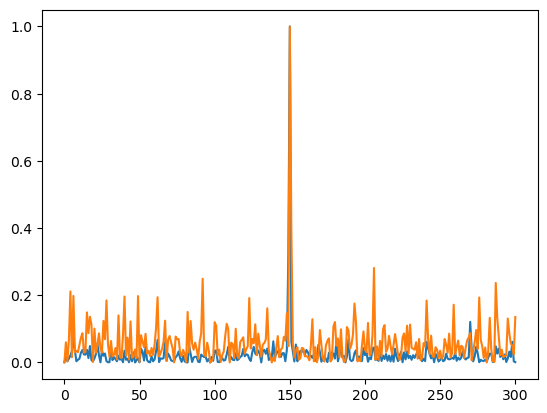

In [7]:
plt.plot(a1g[0])
plt.plot(a1g[10])

In [8]:
analyzer_gradient = innvestigate.create_analyzer("lrp.z", best_model)
a1g = np.zeros((samples, nx+1), dtype = np.float64)
for sample in range(samples):
    a1g[sample] = analyzer_gradient.analyze(M_samples[sample][np.newaxis,:])
    a1g[sample] /= np.max(np.abs(a1g[sample]))
    

2023-06-27 17:41:37.613985: W tensorflow/c/c_api.cc:291] Operation '{name:'kernel_5/Assign' id:624 op device:{requested: '', assigned: ''} def:{{{node kernel_5/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_5, kernel_5/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 17:41:37.647869: W tensorflow/c/c_api.cc:291] Operation '{name:'gradients_5/MaxNeuronSelection_1/Max_grad/range' id:634 op device:{requested: '', assigned: ''} def:{{{node gradients_5/MaxNeuronSelection_1/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection_1/Max"], _has_manual_control_dependencies=true](gradients_5/MaxNeuronSelection_1/Max_grad/range/start, gradients_5/MaxNeuronSelection_1/Max_grad/Size, gradients_5/MaxNeuronSele

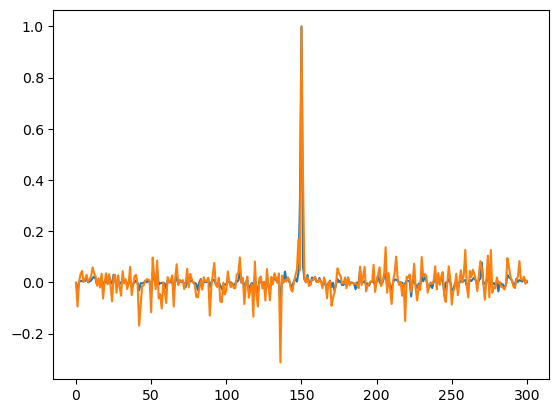

In [9]:
plt.plot(a1g[0])
plt.plot(a1g[10])

In [17]:
def regression_letzgus(model, input_, y_ref, step_width=0.00005, max_it=10e4, method = "flood"):
    
    ### Finding a_ref for a given y_ref
    
    if method == "flood":
        
        model_part = Model(inputs=model.input,
                          outputs=model.layers[-2].output)
        a_ref = model_part.predict(input_)[0,:]
        a_ref = a_ref[:, np.newaxis]
        update = np.ones(a_ref.shape) * step_width
        
        y = model.predict(input_)
        
        counter = 0
        
        if y > y_ref:
            
            while y >= y_ref:
                
                a_ref = np.maximum(np.zeros(a_ref.shape),a_ref-update)
                y = np.dot(model.layers[-1].get_weights()[0][:,0], a_ref[:,0])
                counter +=1 
                print(f'iteration {counter} - y: {y}', end='\r')
                if counter > max_it:
                    print(f'! reference value {y_ref} was not reached within {round(max_it)} iterations!')
                    break
        else:
            
            while y <= y_ref:
                
                a_ref = np.maximum(np.zeros(a.shape),a_ref+update)
                y = np.dot(model.layers[-1].get_weights()[0][:,0], a_ref[:,0])
                counter +=1 
                print(f'iteration {counter} - y: {y}', end='\r')
                if counter > max_it:
                    print(f'! reference value {y_ref} was not reached within {round(max_it)} iterations!')
                    break
                    
    else: 
        
        raise ValueError("The only methods available are : flood")
        
    return a_ref

def triplicated_model(best_model, a_ref):
    
    # get weights and biases
    W_in = best_model.layers[-2].get_weights()[0]
    W_out = best_model.layers[-1].get_weights()[0]
    bias_in = best_model.layers[-2].get_weights()[1]

    inputs = Input(shape=(nx+1,))

    # layer_dict = dict([(layer.name, layer) for layer in model.layers[:-2]])
    # weights = layer_dict['some_name'].get_weights()

    dense11 = Dense(10, activation='relu', name='dense11')
    dense12 = Dense(10, activation='relu', name='dense12')
    dense13 = Dense(10, activation='relu', name='dense13')
    dense21 = Dense(1, activation='linear', use_bias=False, name='dense21')
    dense22 = Dense(1, activation='linear', use_bias=False, name='dense22')
    dense23 = Dense(1, activation='linear', use_bias=False, name='dense23')

    x1 = dense11(inputs)
    x2 = dense12(inputs)
    x3 = dense13(inputs)

    x1 = dense21(x1)
    x2 = dense22(x2)
    x3 = dense23(x3)

    model = keras.Model(inputs=inputs, outputs=x1+x2+x3) 
    
    def getLayerIndexByName(model, layername):
        for idx, layer in enumerate(model.layers):
            if layer.name == layername:
                return idx
            
    model.layers[getLayerIndexByName(model, 'dense11')].set_weights([W_in, bias_in-a_ref[:,0]])
    model.layers[getLayerIndexByName(model, 'dense12')].set_weights([-W_in, -bias_in])                 
    model.layers[getLayerIndexByName(model, 'dense13')].set_weights([-W_in, -bias_in+a_ref[:,0]])
    
    model.layers[getLayerIndexByName(model, 'dense21')].set_weights([W_out])
    model.layers[getLayerIndexByName(model, 'dense22')].set_weights([W_out])
    model.layers[getLayerIndexByName(model, 'dense23')].set_weights([-W_out])
    
    model.compile(loss='mse', optimizer='adam',metrics=['mae'])
    
    return model

In [18]:
y_ref = 0.03

best_model = keras.Model(inputs=inputs, outputs=x) 
best_model.load_weights(mod_h5)
best_model.compile(loss='mse', optimizer='adam',metrics=['mae'])
a = best_model.layers[-1].get_weights()[0]

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
a_ref = regression_letzgus(model_reg, M_samples[np.newaxis, 0], y_ref)

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
tri_model = triplicated_model(model_reg, a_ref)
y_reg = tri_model.predict(M_samples[np.newaxis, 0])
y = best_model.predict(M_samples[np.newaxis, 0])

y_ref, y-y_reg, y, y_reg

2023-06-27 17:44:45.053548: W tensorflow/c/c_api.cc:291] Operation '{name:'count_18/Assign' id:2108 op device:{requested: '', assigned: ''} def:{{{node count_18/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_18, count_18/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 17:44:45.167274: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/Relu' id:308 op device:{requested: '', assigned: ''} def:{{{node dense_2/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 17:44:45.225303: W te

2023-06-27 17:44:45.547768: W tensorflow/c/c_api.cc:291] Operation '{name:'count_20/Assign' id:2204 op device:{requested: '', assigned: ''} def:{{{node count_20/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_20, count_20/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 17:44:45.797967: W tensorflow/c/c_api.cc:291] Operation '{name:'dense21_4/kernel/Assign' id:2327 op device:{requested: '', assigned: ''} def:{{{node dense21_4/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense21_4/kernel, dense21_4/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error 

(0.03,
 array([[0.02985256]], dtype=float32),
 array([[0.04146188]], dtype=float32),
 array([[0.01160933]], dtype=float32))

In [19]:
y_ref = 0.05

best_model = keras.Model(inputs=inputs, outputs=x) 
best_model.load_weights(mod_h5)
best_model.compile(loss='mse', optimizer='adam',metrics=['mae'])
a = best_model.layers[-1].get_weights()[0]

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
a_ref = regression_letzgus(model_reg, M_samples[np.newaxis, 0], y_ref)

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
tri_model = triplicated_model(model_reg, a_ref)
y_reg = tri_model.predict(M_samples[np.newaxis, 0])
y = best_model.predict(M_samples[np.newaxis, 0])

y_ref, y-y_reg, y, y_reg

2023-06-27 17:44:46.646354: W tensorflow/c/c_api.cc:291] Operation '{name:'total_22/Assign' id:2455 op device:{requested: '', assigned: ''} def:{{{node total_22/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_22, total_22/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 17:44:46.764589: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/Relu' id:308 op device:{requested: '', assigned: ''} def:{{{node dense_2/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 17:44:46.829253: W te

2023-06-27 17:44:47.206025: W tensorflow/c/c_api.cc:291] Operation '{name:'total_24/Assign' id:2551 op device:{requested: '', assigned: ''} def:{{{node total_24/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_24, total_24/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 17:44:47.477409: W tensorflow/c/c_api.cc:291] Operation '{name:'dense11_5/bias/Assign' id:2612 op device:{requested: '', assigned: ''} def:{{{node dense11_5/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense11_5/bias, dense11_5/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't

(0.05,
 array([[0.05005603]], dtype=float32),
 array([[0.04146188]], dtype=float32),
 array([[-0.00859415]], dtype=float32))